## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## Hyperparameter Setting

In [2]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [4]:
train_df = pd.read_csv('./data/open/train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./data/open/test.csv')

In [5]:
train_df['SAMPLE_PATH']=train_df['SAMPLE_PATH'].str.replace('./train','./data/open/train')

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./data/open/train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./data/open/train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./data/open/train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./data/open/train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./data/open/train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./data/open/train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./data/open/train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./data/open/train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./data/open/train/TRAIN_1277.wav,2,0


In [6]:
test_df['SAMPLE_PATH']=test_df['SAMPLE_PATH'].str.replace('./test','./data/open/test')

In [14]:
test_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./data/open/test/TEST_0000.wav,2
1,TEST_0001,./data/open/test/TEST_0001.wav,2
2,TEST_0002,./data/open/test/TEST_0002.wav,0
3,TEST_0003,./data/open/test/TEST_0003.wav,0
4,TEST_0004,./data/open/test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./data/open/test/TEST_1509.wav,0
1510,TEST_1510,./data/open/test/TEST_1510.wav,2
1511,TEST_1511,./data/open/test/TEST_1511.wav,0
1512,TEST_1512,./data/open/test/TEST_1512.wav,0


In [10]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features

In [12]:
train_features = get_mfcc_feature(train_df)
test_features = get_mfcc_feature(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

In [18]:
train_0_features = get_mfcc_feature(train_df[train_df['FAN_TYPE']==0])
test_0_features = get_mfcc_feature(test_df[test_df['FAN_TYPE']==0])

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

In [19]:
train_2_features = get_mfcc_feature(train_df[train_df['FAN_TYPE']==2])
test_2_features = get_mfcc_feature(test_df[test_df['FAN_TYPE']==2])

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

## Model Fit

In [22]:
model0 = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model0.fit(train_0_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [23]:
model2 = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model2.fit(train_2_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [26]:
test_pred_proba0 = model0.decision_function(test_0_features)

threshold = 0
pred0 = (test_pred_proba0<threshold)*1

(array([ 10.,  41.,  82.,  74., 135., 134.,  72.,  40.,  69., 122.]),
 array([-9.71800617e-02, -7.28658256e-02, -4.85515895e-02, -2.42373535e-02,
         7.68826186e-05,  2.43911187e-02,  4.87053548e-02,  7.30195909e-02,
         9.73338269e-02,  1.21648063e-01,  1.45962299e-01]),
 <BarContainer object of 10 artists>)

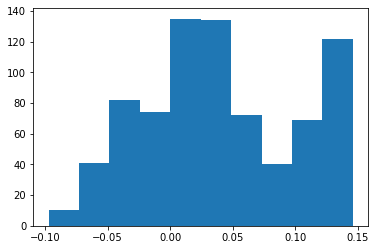

In [27]:
import matplotlib.pyplot as plt

plt.hist(test_pred_proba0)

In [34]:
pred0.mean()

0.2644415917843389

In [30]:
test_pred_proba2 = model2.decision_function(test_2_features)

threshold = -0.05
pred2 = (test_pred_proba2<threshold)*1

(array([ 30.,  70.,  85.,  97., 121.,  56.,  62.,  56.,  59.,  99.]),
 array([-0.14089196, -0.11344554, -0.08599911, -0.05855269, -0.03110627,
        -0.00365985,  0.02378658,  0.051233  ,  0.07867942,  0.10612584,
         0.13357226]),
 <BarContainer object of 10 artists>)

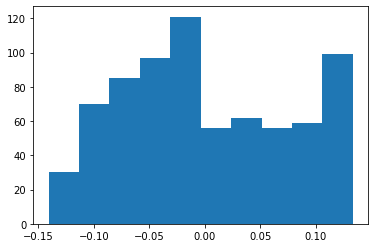

In [31]:
import matplotlib.pyplot as plt

plt.hist(test_pred_proba2)

In [33]:
pred2.mean()

0.2789115646258503

## Prediction

In [85]:
# def get_pred_label(model_pred):
#     # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
#     model_pred = np.where(model_pred == 1, 0, model_pred)
#     model_pred = np.where(model_pred == -1, 1, model_pred)
#     return model_pred

In [86]:
# test_pred = model.predict(test_features) # model prediction
# test_pred = get_pred_label(test_pred)

## Submission

In [35]:
submit = pd.read_csv('./data/open/sample_submission.csv')

In [41]:
test_df2=test_df[test_df['FAN_TYPE']==2]
test_df2['LABEL']=pred2

In [42]:
test_df0=test_df[test_df['FAN_TYPE']==0]
test_df0['LABEL']=pred0

In [49]:
submit=pd.concat( [ test_df0[['SAMPLE_ID','LABEL']], test_df2[['SAMPLE_ID','LABEL']]], axis=0)
submit=submit.sort_values(by='SAMPLE_ID')

In [50]:

submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,0


In [51]:
submit.to_csv('./submit.csv', index=False)